# Twitter Airline Sentiment Analysis

In [1136]:
''' Structure of notebook.
Model uses 'bag-of-words approach' with TF-IDF to create a sparse matrix, which connects 
words to sentiment using Logistic Regression.

The predictions from this Logistic Regression are used as features in a Random Forest,
in tandem with features engineered (engineered features use knowledge gained from EDA).

Accuracy, f1_score, and confusion matrices are used to check strength of models. 
''';

#### Basic Imports

In [1084]:
import pandas as pd
pd.options.display.max_columns = 40
pd.set_option('display.max_colwidth', -1)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('Tweets.csv')

# Data Prep

## Initial EDA

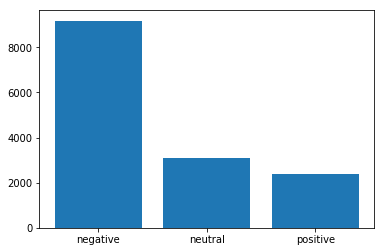

In [1085]:
# Let's see how balanced our classes are.
sentiment_counts = df['airline_sentiment'].value_counts()
plt.bar(sentiment_counts.index.values, height=sentiment_counts );
#Not very balanced. Models will skew towards negative. We can weight neutrals and positives in our model.

In [1086]:
#And let's see their ratios.
sentiment_ratios = df['airline_sentiment'].value_counts(normalize=True)
sentiment_ratios

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

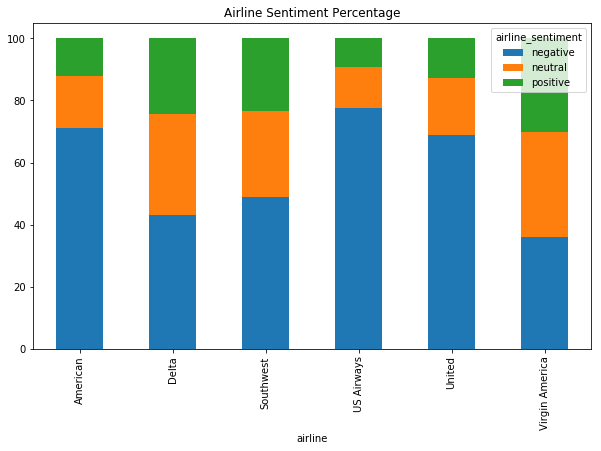

In [1087]:
#Looking at the proportion of negative/neutral/positive by airline
airline_sentiment = pd.crosstab(df['airline'], df['airline_sentiment'])
percent=airline_sentiment.apply(lambda group: group / group.sum() * 100, axis=1)
percent.plot(kind='bar',figsize=(10, 6),stacked=True,title="Airline Sentiment Percentage");

In [1088]:
'''
What are airline_sentiment_gold and negative_reason_gold? very few values. maybe opinions of gold (vip) flyers?
''';

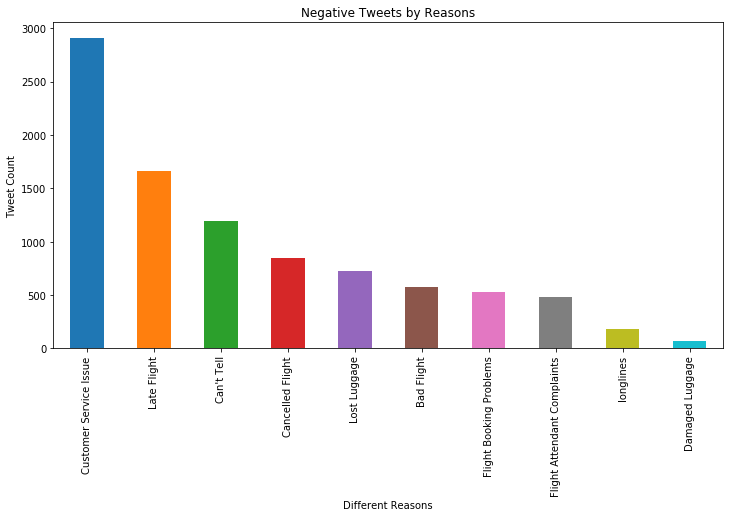

In [1089]:
#Let's see how many tweets are in each category
pd.Series(df["negativereason"]).value_counts().plot(kind = "bar",figsize=(12,6),title = "Negative Tweets by Reasons")
plt.xlabel('Different Reasons', fontsize=10)
plt.ylabel('Tweet Count', fontsize=10);

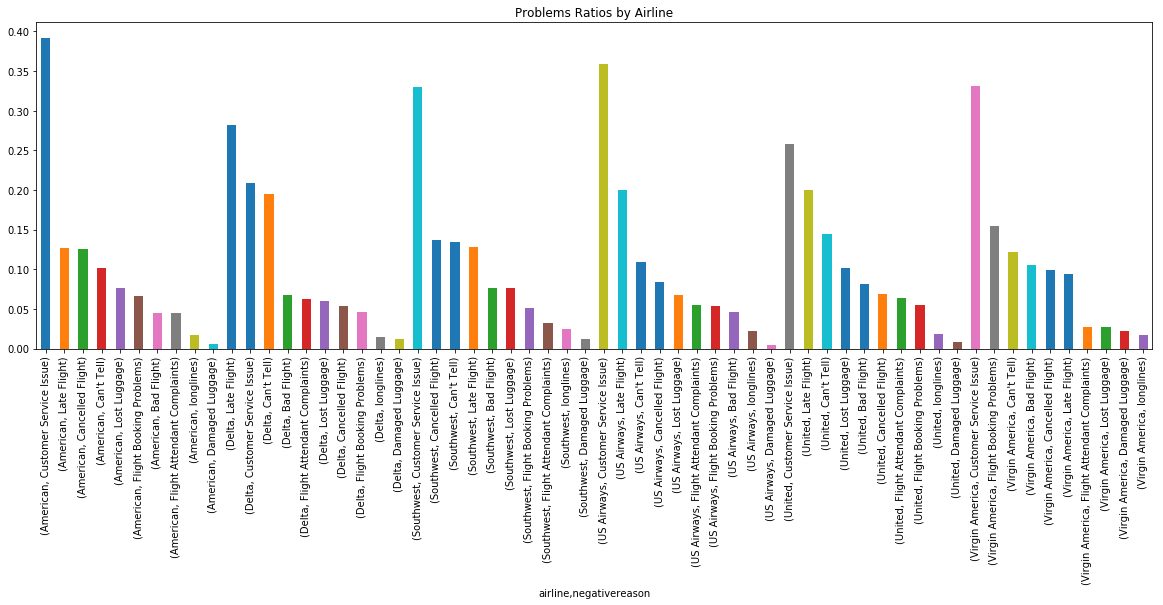

In [1090]:
# What are the proportions of each individual Airline's problems?

df_negative = df.loc[df['airline_sentiment'] == 'negative']         #negative records
airline_problems = df_negative.groupby(['airline'])['negativereason'].value_counts(normalize=True)   
airline_problems.plot(kind = 'bar',figsize = (20,6),title = 'Problems Ratios by Airline');

In [1091]:
'''
Things we see:

1) Most issues are related to Customer Service. 
This ratio is the worst for American Airlines.

2) Delta's largest problem was with their flights being late.

3) Virgin America has a problem with their Booking System.
Through a Google Search, it looks as though customers often had problems with booking through the website.

4) Looks like United Airlines loses luggage at a higher rate than other airlines.


''';

In [1092]:
# checking tweets by user.
# Good chart. Lets make a graph of this.
tweets_by_user = df.groupby(['airline','name'])['airline_sentiment'].value_counts().sort_values(ascending = False)[1:]

#plt.plot(tweets_by_user)

In [1093]:
'''
Note.
Something might not be just positive/negative/neutral. i.e. one tweet talks poorly about United,
and says that Southwest is much better. This is negative for one, positive for the other.

This is likely where people are unsure of labels (giving a confidence of i.e. .3)
''';

In [1094]:
counts_by_day = df.groupby('tweet_created')['tweet_id'].count().reset_index().dropna()


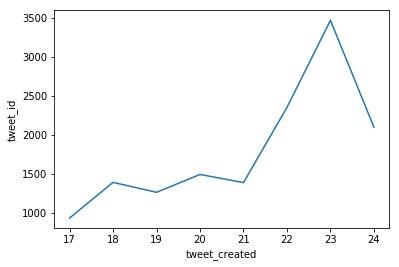

In [1138]:
# We will also see how many tweets are made each day. Also, tiemframe is feb 17-24, 2015.

counts_by_day = df.groupby('tweet_created')['tweet_id'].count().reset_index().dropna()
counts_by_day['tweet_created'] = pd.to_datetime(counts_by_day['tweet_created']).dt.day
sns.lineplot(x='tweet_created', y='tweet_id', data=counts_by_day.groupby('tweet_created')['tweet_id'].sum().reset_index());

In [1096]:
'''
Note, there was a weather storm in this part of February, in 2015.
Could be that more people tweet about travels during a storm.

https://www.weather.gov/media/phi/reports/WSS21Feb2015.pdf
''';

### Drilling into Sentiment Confidence

In [1097]:
#what does sentiment confidence mean?

pos_lo_conf = df.loc[
    (df['airline_sentiment'] == 'positive') & 
    (df['airline_sentiment_confidence'] < .5)][['airline_sentiment','airline_sentiment_confidence','text']]

#After searching through Kaggle, looks like the confidence is the proportion of people that choose the apparent 
#sentiment label (positive/negative/neutral). the lower confidence sentiments are mor ambiguous.
#Perhaps don't use these for training.

In [1098]:
'''how does confidence map to the original tweets?''';
#df[['airline_sentiment','airline_sentiment_confidence','text']]

In [1099]:
# And the tweets that labellers are unsure about?
df.loc[df['airline_sentiment_confidence'] < .5][['airline_sentiment','airline_sentiment_confidence','text']];
'''
These are often ambiguous.
We can remove these and only train on labels we're confident about.
''';

### End of Sentiment

# Cleaning

In [1100]:
#make time a pandas datetime object. so we can work with it.
#Note, -800 at end of time may mean gmt -8 hours.
df['tweet_created'] = pd.to_datetime(df['tweet_created'])

In [1101]:
#On a preliminary run-through, lets only work with tweet (labels) we have >.5 confidence in.
df = df.loc[df['airline_sentiment_confidence'] > .5]

In [1102]:
#df.head(40)

### Preprocessing

In [1103]:
#remove undesirable characters with regular expressions
import re
import string

In [1104]:
# Data has punctuation, numbers. likely not good for training.

In [1105]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)                                   # keep only letters
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower()) # keep only lowercase
df['text'] = df['text'].map(alphanumeric).map(punc_lower)               #run each tweet through both functions
#keep emojis as well.
#something like a heart or a frowny face might tell us about sentiment.

### Stemming (To remove suffix)

In [1106]:
# fly, flight, and flying are practically the same word. We will stem our words so that our model doesn't treat these differently.
# LancasterStemmer proves to be far too aggressive. Destroys meaning of words. Opt for PorterStemmer instead.
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

porter = PorterStemmer()

stemmed_text = []

for element in df['text']:                      #Runs through every tweet
    tweet_token =  word_tokenize(element)       #tokenizes each word, so they can be stemmed
    for i, word in enumerate(tweet_token):
        tweet_token[i] = porter.stem(word)      #stemming
    stemmed_text.append(' '.join(tweet_token))  #rejoin tweet

df['text'] = stemmed_text

### Splitting our datapoints

In [1107]:
X = df['text']
Y = df['airline_sentiment']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = .3, random_state = 9)

# End of Data Prep
# ------------------------------------------------------------------------

# More EDA

In [1108]:
#df.info()

In [1109]:
#here, we're seeing pos/neut/negative broken down by location.
#Airports may not be available, but let's see if we can figure it out from there.
dif_cities = df.groupby(['tweet_location'])['airline_sentiment'].value_counts().reset_index(name = 'counts')

In [1110]:
#df.groupby(['tweet_location'])['airline_sentiment'].value_counts().reset_index(name = 'counts')

## TF- IDF

In [1111]:
from sklearn.feature_extraction.text import TfidfVectorizer
'''
TF-IDF can be effective because it will increase weight of term relevance within document, while reducing 
based on use in other documents.

This will vectorize our documents, but while removing words that are common english, and therefore don't
add value to our predictive capability.

This will eventually be passed through our classification algorithms.

''';


In [1112]:
#vectorization portion
tfidf = TfidfVectorizer(stop_words='english')
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

## Metrics for checking models

In [1113]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
'''
F1 score tells a better story than plain accuracy, because it uses precision as well as recall.
Confusion Matrix allows us to check our actual category misplacements.
''';

In [1114]:
#We're going to use Logistic Regression, because it's good for handling a sparse matrix.

## Logistic Regression

In [1115]:
from sklearn.linear_model import LogisticRegression
'''
We're going to use Logistic Regression, because it's good for handling a sparse matrix.
''';

##### Logistic Regression TF IDF

In [1116]:
#We'll weight our neutrals and positives, checking against f1.
lr_tfidf = LogisticRegression(class_weight={'neutral':4, 'positive':5})
lr_tfidf.fit(x_train_tfidf,y_train)
lr_tfidf.score(x_test_tfidf,y_test)

/Users/ankurkejriwal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ankurkejriwal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7908375751966682

In [1117]:
#This is to check the distribution of predictions. We will want to emulate distribution inherent in data.
predicts = []
predicts = [prediction for prediction in lr_tfidf.predict(x_test_tfidf)]
print('negative: {}'.format(predicts.count('negative')), predicts.count('negative')/len(predicts),
      '\n''neutral: {}'.format(predicts.count('neutral')), predicts.count('neutral')/len(predicts),
      '\n''positive: {}'.format(predicts.count('positive')), predicts.count('positive')/len(predicts),
      )
#originally our models defaulted to predicting negatives

negative: 2695 0.6235539102267469 
neutral: 953 0.22049976862563628 
positive: 674 0.15594632114761683


##### Logistic Regression TF-IDF Score

In [1118]:
f1_score(y_test,lr_tfidf.predict(x_test_tfidf),average=None)

array([0.86695906, 0.61899563, 0.71492537])

In [1119]:
'''
This tells us that our model nicely predicts negative reviews, but is a little weaker with the neural and positives.
We can explore the actual misclassifications with a confusion matrix.
''';

In [1120]:
confusion_matrix(y_test,lr_tfidf.predict(x_test_tfidf))

array([[2372,  296,  109],
       [ 226,  567,   86],
       [  97,   90,  479]])

In [1121]:
'''
We see from here that most of our misclassified neutral/positive entries, are erroneously labeled as Negative.
''';

In [1122]:
'''
We can feature engineer, and add these features to the dataframe. Main issue with this, is that TF_IDF dataframe
is a sparse matrix, so anything appended to this risks being drowned out.

What we can do instead, is take the prediction probabilities from the 'bag-of-words' approach, which was fed
through the original logistic regression, and include these predictions as the the features to another model.
The other model, will include features we have engineered.

For the other model, we should use a model which can handle non-linear patterns in the features- i.e.
Random Forest.
''';

## Stacking results with engineered features

In [1123]:
'''
1) Tweet Length
It looks like the negative tweets, seem to be of longer length.

2) Day
It seems as though there were more negative tweets created around the 21-23 of February.
When we explored data, we found that there was a snow storm around this time.

''';

## Training Portion

In [1124]:
#Creating a new dataframe, with the predictions of the logistic regression
probabilities_train=pd.DataFrame(lr_tfidf.predict_proba(x_train_tfidf),columns = ['prob_negative','prob_neutral','prob_positive'], index = x_train.index)

##### Adding feature 'Tweet_Length'

In [1125]:
# Finding length of the tweet
probabilities_train['text'] = df.loc[list(x_train.index)]['text']
probabilities_train['tweet_length'] = probabilities_train.apply(lambda row: len(row['text']), axis = 1)
probabilities_train['airline_sentiment'] = df.loc[list(x_train.index)]['airline_sentiment']

##### Adding feature 'Day'

In [1126]:
#Finding the Day in February
probabilities_train['day'] = df.loc[list(x_train.index)]['tweet_created'].dt.day

## Test Portion

In [1127]:
#populating a dataframe with predictions, using the test set (same as training step above)
probabilities_test = pd.DataFrame(lr_tfidf.predict_proba(x_test_tfidf), columns = ['prob_negative','prob_neutral','prob_positive'], index = x_test.index)

##### Adding feature 'Tweet_Length'

In [1128]:
probabilities_test['text'] = df.loc[list(x_test.index)]['text']
probabilities_test['tweet_length'] = probabilities_test.apply(lambda row: len(row['text']), axis = 1)
probabilities_test['airline_sentiment'] = df.loc[list(x_test.index)]['airline_sentiment']

##### Adding feature 'Day'

In [1129]:
probabilities_test['day'] = df.loc[list(x_test.index)]['tweet_created'].dt.day

## Random Forest

In [1130]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
features = ['prob_negative','prob_neutral','prob_positive','tweet_length','day']
target = ['airline_sentiment']
rf.fit(probabilities_train[features],probabilities_train[target]);

/Users/ankurkejriwal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


#### Fitting Test Set to Random Forest, and checking Results

In [1131]:
#accuracy score.
rf.score(probabilities_test[features],probabilities_test[target])

0.7943081906524757

In [1132]:
#This is our final result. 
f1_score(y_test,rf.predict(probabilities_test[features]), average=None)

array([0.87124845, 0.60487225, 0.70827068])

In [1133]:
confusion_matrix(y_test,rf.predict(probabilities_test[features]))

array([[2453,  221,  103],
       [ 280,  509,   90],
       [ 121,   74,  471]])

## Conclusion

In [1134]:
'''
Using stacked models and engineered features, We are able to correctly classify roughly
80% of tweets.
''';

## For Future Exploration

In [1135]:
'''
In order to further develop the model, I would like to:

1) Make use of Part-of-Speech Tagging.
2) Use transfer learning to learn sentiment better than a "bag of words" approach.
3) Find meaning using the 'emojis' present in the text.
4) See if any particular locations have a relationship with the tags 'negative', 'neutral', and 'positive'

''';